In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime
from scipy import special
from scipy import stats
sns.set(rc={'figure.figsize' : (12, 5)}, font='verdana')
plt.style.use('dark_background')

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Какой набор лучше?

In [4]:
url='https://drive.google.com/file/d/1ZnhQzDliRiOlrADRJV_ZTlxOqqsMo4sc/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url,sep = ';')

In [5]:
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [6]:
df_a = df[df.testgroup == 'a']
df_a.head(1)

,user_id,revenue,testgroup
1,2,0,a


In [7]:
df_b = df[df.testgroup == 'b']
df_b.head(1)

,user_id,revenue,testgroup
0,1,0,b


Проверим все ли записи в обеих группах уникальны

In [7]:
(df_a.user_id.nunique() == len(df_a))*1 + (df_b.user_id.nunique() == len(df_b))*1

2

Посмотрим на общие метрики по группам

In [6]:
print(f'Группа А: \n\
Клиентов всего:       {len(df_a)}\n\
Заплативших клиентов: {len(df_a[df_a.revenue > 0])}    \n\
СR в оплату:          {round(len(df_a[df_a.revenue > 0]) / len(df_a), 4)} \n\
Средний чек:          {round(df_a[df_a.revenue > 0].revenue.sum() / len(df_a[df_a.revenue > 0]),1)} \n\
Самый большой заказ:  {df_a.revenue.max()}\n\
    ')

Группа А: 
Клиентов всего:       202103
Заплативших клиентов: 1928    
СR в оплату:          0.0095 
Средний чек:          2664.0 
Самый большой заказ:  37433
    


In [7]:
print(f'Группа B: \n\
Клиентов всего:       {len(df_b)}\n\
Заплативших клиентов: {len(df_b[df_b.revenue > 0])}    \n\
СR в оплату:          {round(len(df_b[df_b.revenue > 0]) / len(df_b), 4)} \n\
Средний чек:          {round(df_b[df_b.revenue > 0].revenue.sum() / len(df_b[df_b.revenue > 0]),1)} \n\
Самый большой заказ:  {df_b.revenue.max()}\n\
    ')

Группа B: 
Клиентов всего:       202667
Заплативших клиентов: 1805    
СR в оплату:          0.0089 
Средний чек:          3003.7 
Самый большой заказ:  4000
    


Разница в сумме максимального заказа впечатляет. Посмотрим на распределение заказов по сумме

<Figure size 1300x600 with 0 Axes>

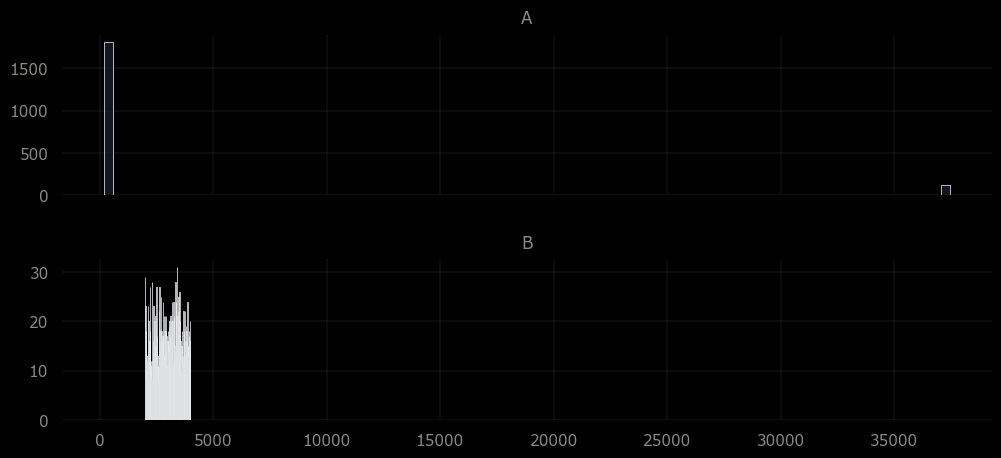

In [10]:
plt.figure(figsize=(13,6))
fig, ax = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(wspace= 0.2, 
                    hspace= 0.4)

plt.subplot(2, 1, 1)
sns.histplot(df_a[df_a.revenue > 0].revenue, linewidth=0.5,color='#171e2f',bins = 100)
plt.tick_params(axis='both', colors='#8b8a84')
plt.title('A', fontsize=12, y=1.02,color='#8b8a84')
plt.ylabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11, color='#8b8a84')


for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.subplot(2, 1, 2)
sns.histplot(df_b[df_b.revenue > 0].revenue, linewidth=0.5,color='#171e2f',bins = 100)
plt.tick_params(axis='both', colors='#8b8a84')
plt.title('B', fontsize=12, y=1.02,color='#8b8a84')
plt.ylabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11, color='#8b8a84')

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.show()

Правая группа в А в районе 40000 - makes a difference. Давайте посмотрим сколько в нем заказов

In [8]:
pd.cut(df_a[df_a.revenue > 0].revenue, bins = 5).value_counts()

revenue
(162.767, 7646.6]     1805
(29986.4, 37433.0]     123
(7646.6, 15093.2]        0
(15093.2, 22539.8]       0
(22539.8, 29986.4]       0
Name: count, dtype: int64

всего 123 заказа, посмотрим на них

In [9]:
df_a.revenue.sort_values().tail(123)

19495     37293
254113    37294
34534     37294
235858    37294
81477     37294
          ...  
142804    37379
21585     37385
65077     37394
196601    37407
101861    37433
Name: revenue, Length: 123, dtype: int64

Все как на подбор

In [21]:
print(f'В группе А в левой группе объем продаж {df_a.revenue.sum() - 37300*123}, а в правой группе {37300*123} \n \
                              то есть {round(100*(df_a.revenue.sum() - 37300*123)/df_a.revenue.sum(),0)}% всех продаж и       {round(100*(37300*123)/df_a.revenue.sum(),0)}%  соответственно')

В группе А в левой группе объем продаж 548289, а в правой группе 4587900 
                               то есть 11.0% всех продаж и       89.0%  соответственно


In [24]:
print(f'выручка группы А с правой группой                                           {df[(df.revenue>0) & (df.testgroup == 'a')].revenue.sum()} \n\
потеря всего 1 заказа из правой группы пенька уменьшает выручку группы А на 37000 или {round(100*37000/df[(df.revenue>0) & (df.testgroup == 'a')].revenue.sum(),1)}% \n\
выручка группы А без правой группы                                          {df[(df.revenue>0) & (df.revenue < 37000) & (df.testgroup == 'a')].revenue.sum()} \n\
выручка группы B                                                            {df[(df.revenue>0) & (df.testgroup == 'b')].revenue.sum()} ')

выручка группы А с правой группой                                           5136189 
потеря всего 1 заказа из правой группы пенька уменьшает выручку группы А на 37000 или 0.7% 
выручка группы А без правой группы                                          545937 
выручка группы B                                                            5421603 


Без правой группы группа А - это всего 10% от группы В.

Хотелось бы понять природу правой группы - это ошибка формирования выборок для теста или неотъемлимая часть промопредложения. Но поскольку спросить не у кого, будем считать ветным второе предположение.

Выберем целевые метирики для нашего исследования. Нас интересует объем продаж покупателей и успешность конвертации посетителей в покупателей. То есть:

ARPPU - среднее этой метрики позволит понять сколько денег нам в среднем заносит каждый покупатель, чем выше этот показатель, тем лучше

CR в покупку - важно с точки зрения затрат на привлечение покупателя, чем больше трафика реализуется, то есть чем выше CR, тем лучше

Построим на распределения групп А и В

ARPPU = Число повторных покупок * Средний чек

In [52]:
print(f' В группе А нет повторных покупок:    {df_a[df_a.revenue > 0].user_id.nunique() == len(df_a[df_a.revenue > 0].user_id)} \n \
В группе В нет повторных покупок:    {df_b[df_b.revenue > 0].user_id.nunique() == len(df_b[df_b.revenue > 0].user_id)}')

 В группе А нет повторных покупок:    True 
 В группе В нет повторных покупок:    True


Чмсло повторных покупок для обеих групп равно 1 (видимо потому что речь идет об акционном наборе, который предлагается одному клиенту один раз), а значит ARPPU в нашем случае равен среднему чеку, то есть отношению всей выручки группы к числу покупок или иначе - среднему распределения выручки по заказам.

In [162]:
print(f'ARPPU контрольный групы А:    {round(df_a[df_a.revenue > 0].revenue.sum() / len(df_a[df_a.revenue > 0]),1)} \n\
ARPPU тестовой групы В:       {round(df_b[df_b.revenue > 0].revenue.sum() / len(df_b[df_b.revenue > 0]),1)} \n\
    ')

ARPPU контрольный групы А:    2664.0 
ARPPU тестовой групы В:       3003.7 
    


ARPPU тестовой группы В выше. Необходимо оценить статистическую значимость этого различия.

Нулевая гипотеза заключается в том, что ARPPU групп А и В не имеют статистически значимых различий.

Выберем тест для проверки нулевой гипотезы.

Распределение группы В очень похоже на равномерное распределение, которое хорошо сходится средними выборок к истинному среднему

<Figure size 1300x600 with 0 Axes>

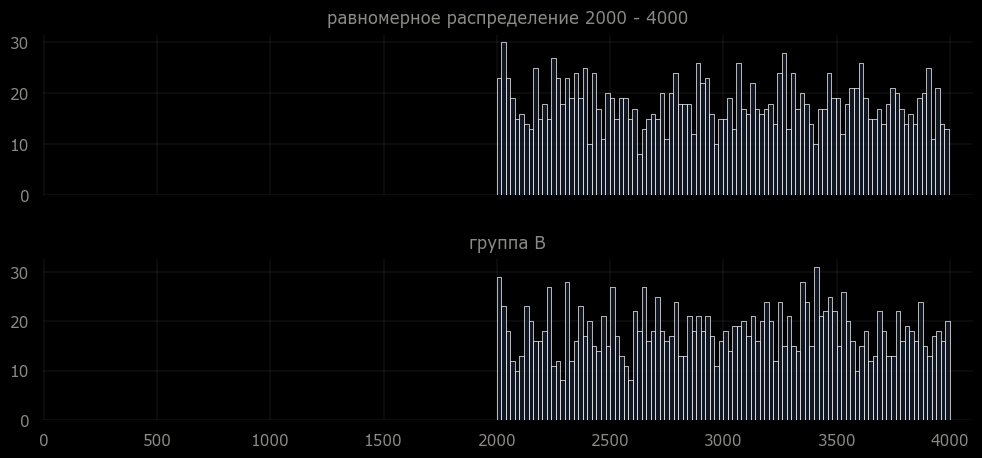

In [58]:
uni = np.random.uniform(2000, 4000, 1805)

plt.figure(figsize=(13,6))
fig, ax = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(wspace= 0.2, 
                    hspace= 0.4)

plt.subplot(2, 1, 1)
sns.histplot(uni, linewidth=0.5,color='#171e2f',bins = 100)
plt.tick_params(axis='both', colors='#8b8a84')
plt.title('равномерное распределение 2000 - 4000', fontsize=12, y=1.02,color='#8b8a84')
plt.ylabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
plt.xlim(-5, 4100)
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.subplot(2, 1, 2)
sns.histplot(df_b[df_b.revenue > 0].revenue, linewidth=0.5,color='#171e2f',bins = 100)
plt.tick_params(axis='both', colors='#8b8a84')
plt.title('группа B', fontsize=12, y=1.02,color='#8b8a84')
plt.ylabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.show()

Группа А похожа на биномиальное распределение, которое  тоже хорошо сходится к своему среднему.

<Figure size 1300x600 with 0 Axes>

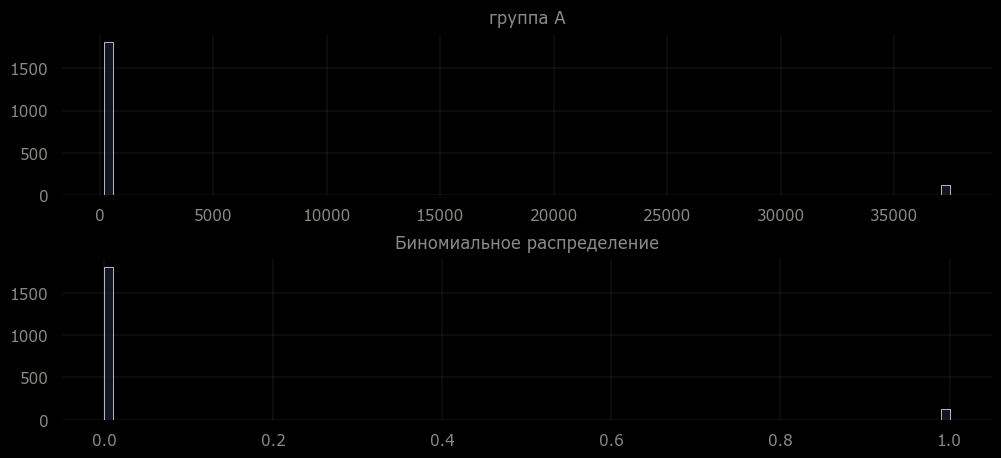

In [25]:
plt.figure(figsize=(13,6))
fig, ax = plt.subplots(2, 1, sharex=False)
plt.subplots_adjust(wspace= 0.2, 
                    hspace= 0.4)

plt.subplot(2, 1, 1)
sns.histplot(df_a[df_a.revenue > 0].revenue, linewidth=0.5,color='#171e2f',bins = 100)
plt.tick_params(axis='both', colors='#8b8a84')
plt.title('группа A', fontsize=12, y=1.02,color='#8b8a84')
plt.ylabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11, color='#8b8a84')


for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.subplot(2, 1, 2)
sns.histplot(np.random.binomial(1,123/(1805+123),1928), linewidth=0.5,color='#171e2f',bins = 100)
plt.tick_params(axis='both', colors='#8b8a84')
plt.title('Биномиальное распределение', fontsize=12, y=1.02,color='#8b8a84')
plt.ylabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11, color='#8b8a84')

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.show()

In [26]:

b_example = np.random.binomial(1,123/(1805+123),1928)
df_bins = pd.DataFrame()
df_bins['a_bins'] = pd.cut(df_a[df_a.revenue > 0].revenue.values, 10).value_counts().values
df_bins['b_bins'] = pd.cut(b_example, 10).value_counts().values 
df_bins

,a_bins,b_bins
0,1805,1805
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,123,123


<Figure size 1300x600 with 0 Axes>

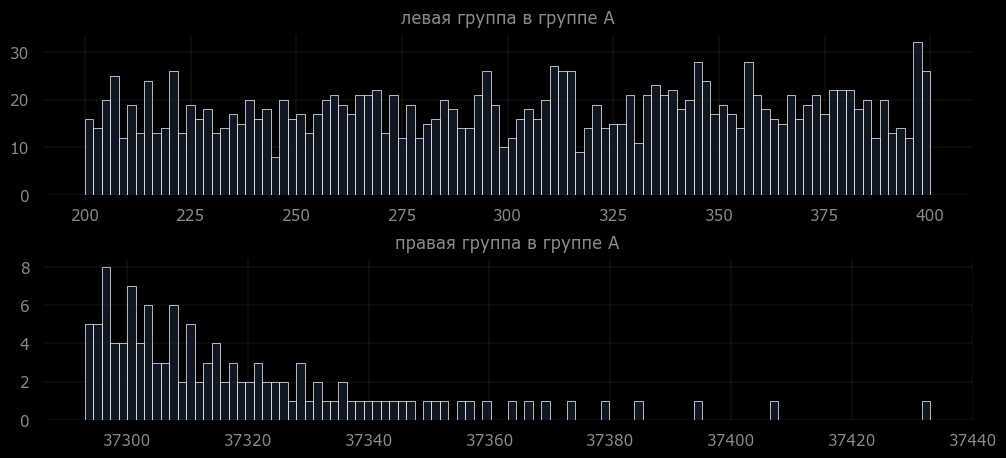

In [39]:
plt.figure(figsize=(13,6))
fig, ax = plt.subplots(2, 1, sharex=False)
plt.subplots_adjust(wspace= 0.2, 
                    hspace= 0.4)

plt.subplot(2, 1, 1)
sns.histplot(df_a[(df_a.revenue > 0)&(df_a.revenue < 20000)].revenue, linewidth=0.5,color='#171e2f',bins = 100)
plt.tick_params(axis='both', colors='#8b8a84')
plt.title('левая группа в группе А', fontsize=12, y=1.02,color='#8b8a84')
plt.ylabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.subplot(2, 1, 2)
sns.histplot(df_a[(df_a.revenue > 0)&(df_a.revenue > 20000)].revenue, linewidth=0.5,color='#171e2f',bins = 100)
plt.tick_params(axis='both', colors='#8b8a84')
plt.title('правая группа в группе А', fontsize=12, y=1.02,color='#8b8a84')
plt.ylabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11, color='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.show()


То есть, биномиальное распределение в группе А определяет из распределения правой или левой части группы будет взято значение выборки. 

С этой точки зрения появление 123 дорогих заказов в определенной пропорции к дешевым можно легко объяснить, например так: каждый 10-й заказ получает суперскидку на дорогой товар (покупают со скидкой не все, поэтому доля дорогих заказов ниже 10%). 

Получается, что группа В  - равномерное распределение, группа А - имеет биномиальное распределение. При этом оба хорошо сходятся.

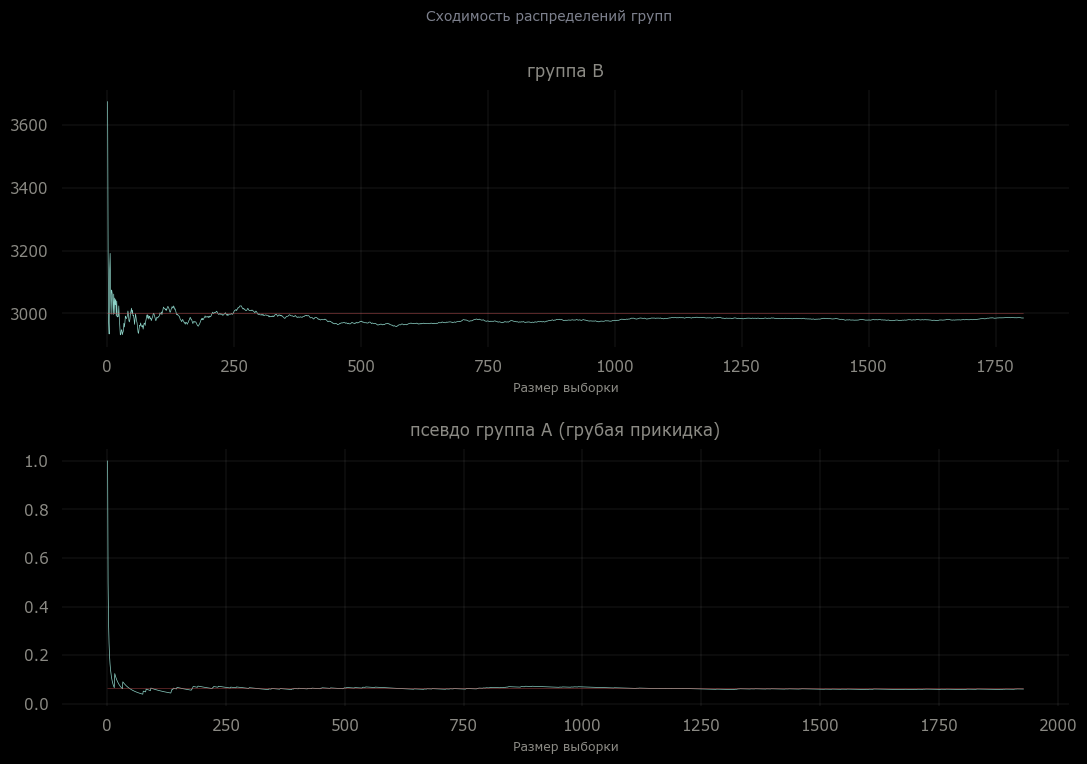

In [63]:
plt.figure(figsize=(13,8))
plt.subplots_adjust(wspace= 0.2, 
                    hspace= 0.4)


plt.suptitle('Сходимость распределений групп', fontsize=10, color='#7d808d')

plt.subplot(2, 1, 1)
t1 = pd.Series(np.random.uniform(2000, 4000, 1805)).to_frame()
t1.columns=['res']
t1['csum']=t1['res'].cumsum()
t1['num']=range(1,1806)
t1['cmean']=t1.csum/t1.num

plt.plot(t1.num, t1.cmean, linewidth=0.5)
plt.plot(t1.num, np.array([3000]*1805), '-r',linewidth=0.3)
plt.title('группа В', fontsize=12, y=1.02, color='#8b8a84')
plt.xlabel("Размер выборки", labelpad = 5, fontsize= 9,color='#8b8a84')
plt.tick_params(axis='both', colors='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.subplot(2, 1, 2)
t1 = pd.Series(np.random.binomial(1,123/(1805+123),1928)).to_frame()
t1.columns=['res']
t1['csum']=t1['res'].cumsum()
t1['csum'] = t1['csum']
t1['num']=range(1,1929)
t1['cmean']=t1.csum/t1.num
plt.plot(t1.num, t1.cmean, linewidth=0.5)
plt.plot(t1.num, np.array([t1.cmean.mean()]*1928), '-r',linewidth=0.3)
plt.tick_params(axis='both', colors='#8b8a84')
plt.title('псевдо группа А (грубая прикидка)', fontsize=12, y=1.02,color='#8b8a84')
plt.xlabel("Размер выборки", labelpad = 5, fontsize= 9,color='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.show()

Посмотрим как распределяются средние распределений с учетом размеров выборок

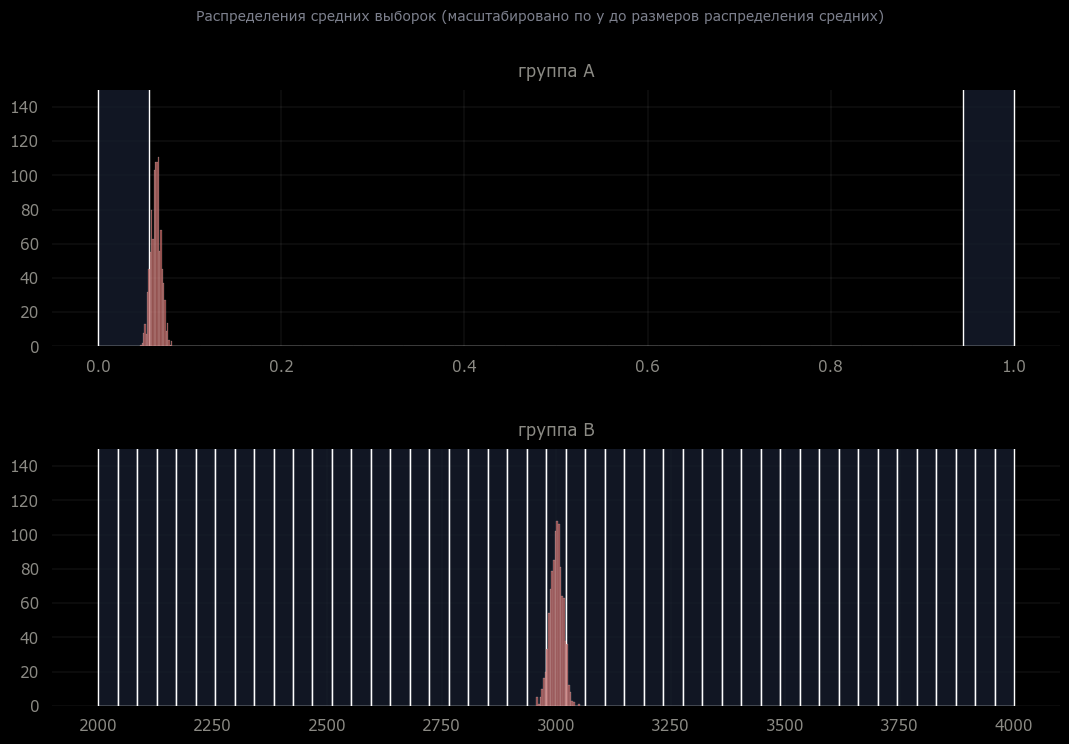

In [164]:
plt.figure(figsize=(13,8))
plt.subplots_adjust(wspace= 0.2, 
                    hspace= 0.4)

plt.suptitle('Распределения средних выборок (масштабировано по y до размеров распределения средних)', fontsize=10, color='#7d808d')

plt.subplot(2, 1, 1)
t3 = np.random.binomial(1,123/(1805+123),100000)
t3_se = [pd.Series(t3).sample(1928).mean() for _ in range(1000)]
sns.histplot(t3, color='#171e2f')
sns.histplot(t3_se, color='#ba5a58')
plt.ylim(0, 150)
plt.title('группа А', fontsize=12, y=1.02, color='#8b8a84')
plt.ylabel("", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.tick_params(axis='both', colors='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.subplot(2, 1, 2)
t4 = np.random.uniform(2000, 4000, 100000)
t4_se = [pd.Series(t4).sample(1805).mean() for _ in range(1000)]
sns.histplot(t4, color='#171e2f')
sns.histplot(t4_se, color='#ba5a58')
plt.ylim(0, 150)
plt.ylabel("", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.title('группа В', fontsize=12, y=1.02, color='#8b8a84')
plt.tick_params(axis='both', colors='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.show()

Проверим нормальность распределений средних

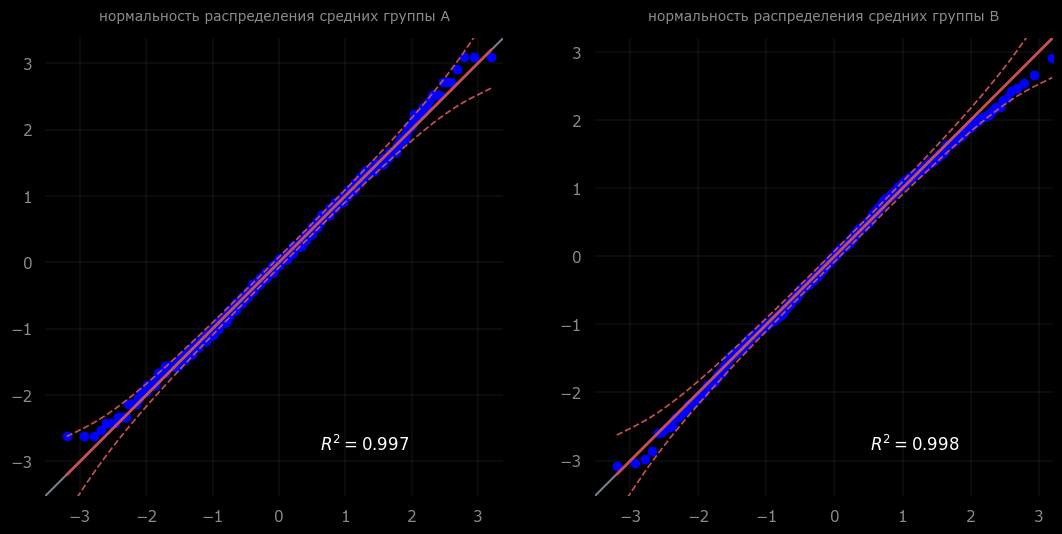

In [66]:
plt.figure(figsize=(13,8))
plt.subplots_adjust(wspace= 0.2, 
                    hspace= 0.4)

plt.subplot(1, 2, 1)
pg.qqplot(t3_se)
plt.title('нормальность распределения средних группы А', fontsize=10, y=1.02, color='#8b8a84')
plt.ylabel("", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.tick_params(axis='both', colors='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.subplot(1, 2, 2)
pg.qqplot(t4_se)
plt.xlabel("", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.ylabel("", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.title('нормальность распределения средних группы В', fontsize=10, y=1.02, color='#8b8a84')
plt.tick_params(axis='both', colors='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.show()

С учетом размера выборок и нормальности распределения средних мы можем использовать t-test для определения статистической значимости разлиичий ARPPU групп А и В

In [84]:
pg.ttest(df_a[df_a.revenue > 0].revenue, df_b[df_b.revenue > 0].revenue)['p-val']


T-test    0.100208
Name: p-val, dtype: float64

При условии неравенства выборок в данном т-тесте автоматически применяется вариант т-теста Welch-а. P-value в 10% не позволяет нам отвергнуть нулевую гипотезу об отсутствии различия между ARPPU тестовой и контрольной групп. 

А значит наш вывод  на основе имеющихся данных: ARPPU в тестовой и контрольной группе статистически значимо не различается.

Теперь посмотрим на метрику CR  в покупку. Имеем следующие данные по группам.

In [141]:
df_cr = pd.DataFrame({'a' : [len(df_a[df_a.revenue > 0]), len(df_a) - len(df_a[df_a.revenue > 0])],\
                      'b' : [len(df_b[df_b.revenue > 0]), len(df_b) - len(df_b[df_b.revenue > 0])]},\
                       index = ['active', 'not_active'])

In [142]:
df_cr = df_cr.transpose().copy()
df_cr

,active,not_active
a,1928,200175
b,1805,200862


Нулевая гипотеза состоит в том, что CR в покупку (то есть отношение сделавших покупку к общему числу клиентов) статистически значимо не различается для тестовой и контрольной групп.

И поскольку CR является категориальной переменной - используем метод Хи-квадрат

In [151]:
print(f'p-value: {round(stats.chi2_contingency(df_cr)[1], 4)}')

p-value: 0.0365


Полученное значение p-value позволяет отклонить нулевую гипотезу и сделать вывод о том, что CR в покупку в тестовой и контрольной группе статистически значимо различаются.

In [157]:
print(f'CR контрольной группы А:   {round(len(df_a[df_a.revenue > 0])*100 / len(df_a), 2)}% \n\
CR тестовой группы В:      {round(len(df_b[df_b.revenue > 0]) *100/ len(df_b), 2)}%')

CR контрольной группы А:   0.95% 
CR тестовой группы В:      0.89%


Выводы: 

- Различия в ARPPU тестовой и контрольной групп не имеют статистической значимости
- CR в покупку контрольной группы выше чем тестовой и это различие статистически значимо

Делаем выбор в пользу контрольной группы.